# Massmord # 
-----
## En datadriven story ##
#### Av ARoos, EUD, JF och MG ###



### Intro
-----

#### 
- **Vem är vi**
- **Varför behövs avancerad analys**
- **Samhällsproblem/Affärsproblem**
- **Frågeställning**

Vilka faktorer har störst betydelse på antalet offer?
- Angriparens ålder
- Platsen
- Vapnen

### Data-prep
---------

#### Import Data

In [2]:
# Libraries

import pandas as pd

from functools import reduce

In [29]:
# Data source

df_incidents = pd.read_csv('mass_killing_incidents_public.csv')
df_offenders = pd.read_csv('mass_killing_offenders_public.csv')
df_weapons = pd.read_csv('mass_killing_weapons_public.csv')

In [30]:
# Aggregate new data

df_incidents['was_rifle_used'] = df_incidents['if_assault_rifle_used'].apply(
    lambda x: 1 if x in ['AR-15 style', 'Other assault rifle'] else 0)

df_offenders_avg_age = df_offenders.groupby('incident_id').agg({'age': 'mean'})

df_weapons['gun_count'] = df_weapons['weapon_type'].apply(lambda x: 1 if x == 'gun' else 0)

df_weapons = df_weapons.groupby('incident_id').agg({'gun_count': 'sum'})

In [31]:
# Variable and column normalization

df_incidents_rifle = df_incidents
df_weapons_gun_count = df_weapons
df_offenders_avg_age = df_offenders_avg_age.rename(columns={'age': 'avg_offender_age'})


In [7]:
# Check dfs

#df_incidents_rifle
#df_weapons_gun_count
df_offenders_avg_age

,avg_offender_age
incident_id,
1,36.5
2,47.0
3,51.0
4,33.0
5,26.0
...,...
653,45.0
655,40.0
656,29.0


In [68]:
# Data merge and check

df_list = [df_incidents_rifle, df_weapons_gun_count, df_offenders_avg_age]

merged_df = reduce(
    lambda left, right: pd.merge(left, right, on='incident_id', how='inner'),
    df_list)

print(merged_df.columns)

Index(['incident_id', 'date', 'city', 'state', 'num_offenders',
       'num_victims_killed', 'num_victims_injured', 'firstcod', 'secondcod',
       'if_assault_rifle_used', 'type', 'situation_type', 'location_type',
       'location', 'longitude', 'latitude', 'county', 'census_tract_geoid',
       'narrative', 'was_rifle_used', 'gun_count', 'avg_offender_age'],
      dtype='object')


In [70]:
# Column filtering and check

columns_to_keep = ['incident_id', 'date', 'state', 'gun_count', 'was_rifle_used', 
                   'location_type', 'avg_offender_age', 'num_victims_injured', 
                   'num_victims_killed']

filtered_df = merged_df[columns_to_keep]

print(filtered_df.columns)

Index(['incident_id', 'date', 'state', 'gun_count', 'was_rifle_used',
       'location_type', 'num_offenders', 'avg_offender_age',
       'num_victims_injured', 'num_victims_killed'],
      dtype='object')


In [71]:
# Check null

filtered_df.isnull().sum()

incident_id             0
date                    0
state                   0
gun_count               0
was_rifle_used          0
location_type           0
num_offenders           0
avg_offender_age       34
num_victims_injured     0
num_victims_killed      0
dtype: int64

In [72]:
# Handle missing data with median

median_age_df = filtered_df['avg_offender_age'].median()
filtered_no_na_df = filtered_df.copy()
filtered_no_na_df.loc[:, 'avg_offender_age'] = filtered_df['avg_offender_age'].fillna(median_age_df)

In [73]:
filtered_no_na_df
filtered_no_na_df.isnull().sum()

incident_id            0
date                   0
state                  0
gun_count              0
was_rifle_used         0
location_type          0
num_offenders          0
avg_offender_age       0
num_victims_injured    0
num_victims_killed     0
dtype: int64

In [88]:
# Check final dataset
master_na_df = filtered_df
master_df = filtered_no_na_df

#master_na_df
master_df

,incident_id,date,state,gun_count,was_rifle_used,location_type,num_offenders,avg_offender_age,num_victims_injured,num_victims_killed
0,657,2025-10-12,SC,1,0,Commercial/Retail/Entertainment,1,32.0,20,4
1,656,2025-10-10,MS,1,0,Open space,4,29.0,10,6
2,655,2025-09-28,MI,1,1,House of Worship,1,40.0,8,4
3,658,2025-08-11,OR,1,0,Residence/Other shelter,1,40.0,0,4
4,653,2025-08-01,MT,1,0,Commercial/Retail/Entertainment,1,45.0,0,4
...,...,...,...,...,...,...,...,...,...,...
622,95,2006-03-15,MI,1,0,Residence/Other shelter,1,32.0,0,4
623,232,2006-02-24,NY,0,0,Residence/Other shelter,1,32.0,1,4
624,97,2006-02-21,AZ,2,0,Residence/Other shelter,1,28.0,0,5
625,109,2006-01-30,CA,1,0,Government/Transit,1,44.0,0,7


In [230]:
# Filtering data for model use

columns_to_keep_in_model = ['location_type', 'gun_count', 'was_rifle_used', 
                            'avg_offender_age', 'num_victims_killed']

model_df = master_df[columns_to_keep_in_model]

In [111]:
model_df.dtypes

location_type          object
gun_count               int64
was_rifle_used          int64
avg_offender_age      float64
num_victims_killed      int64
dtype: object

In [127]:
model_df

,location_type,gun_count,was_rifle_used,avg_offender_age,num_victims_killed
0,Commercial/Retail/Entertainment,1,0,32.0,4
1,Open space,1,0,29.0,6
2,House of Worship,1,1,40.0,4
3,Residence/Other shelter,1,0,40.0,4
4,Commercial/Retail/Entertainment,1,0,45.0,4
...,...,...,...,...,...
622,Residence/Other shelter,1,0,32.0,4
623,Residence/Other shelter,0,0,32.0,4
624,Residence/Other shelter,2,0,28.0,5
625,Government/Transit,1,0,44.0,7


In [160]:
# Saving data

master_na_df.to_parquet('massmord_master_na_data.parquet')
master_df.to_parquet('massmord_master_data.parquet')
model_df.to_parquet('massmord_model_data.parquet')


#### Encode Categorical Data

In [193]:
# Libraries

import numpy as np 

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

In [194]:
# Independent Variables (X)

X = model_df.iloc[:, :-1].values # all columns except last
y = model_df.iloc[:, -1].values # last column

# passthrough meaning we will leave the other columns untouched.
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [0])], remainder='passthrough')

X = np.array(ct.fit_transform(X))
print(X)
print(type(X))

[[1.0 0.0 0.0 ... 1 0 32.0]
 [0.0 0.0 0.0 ... 1 0 29.0]
 [0.0 0.0 1.0 ... 1 1 40.0]
 ...
 [0.0 0.0 0.0 ... 2 0 28.0]
 [0.0 1.0 0.0 ... 1 0 44.0]
 [0.0 0.0 0.0 ... 0 0 28.0]]
<class 'numpy.ndarray'>


In [195]:
#Dependent Variable (y)

le = LabelEncoder()
y = le.fit_transform(y) # a np.array is not needed here.

print(y)

[ 0  2  0  0  0  0  0  0  0  0  0  0  0  0  0 10  0  0  0  0  0  0  1  1
  0  0  0  0  0  0  0  1  0  1  0  1  0  0  0  0  0  0  1  0  0  0  0  0
  1  2  0  4  0  0  2  0  0  0  0 12  1  0  0  0  0  0  1  2  0  1  0  0
  4  0  0  2  1  0  0  1  0  2  0  0  0  0  0  0  2  0  3  7  2  0  0  3
  0  2  1  0  0  0  0  0  0  0  3  1  0  0  1  0  1  0  0  1  0  0  0  0
  0  0  3  0  1  0  0 13  6  0  0  0  0  2  0  1  2  0  0  1  0  0  1  2
  0  0  0  0  0  0  0  0  0  0  0  1  0  0  5  0  2  0  4  2  0  0  0  6
  4  0  2  1  1  0  0  0  1  0  3  0  1  0  0  0  0  1  1  3  1  0  0  2
  0  1  0  0  0  0  0  0  1  1  0  1  0  0  0  0  0  0  1  3  0  5 14  0
  0  0  1  0  1  0  0  0  1  8  0  0  3  0  1  0  0  0  1  0  1  0  0  1
  0  1  0  0  0  0  8  7  0  0  1  0  0  1  1  2  6  0  0  0  2  0  0  0
 11  0  0  0  0  0  1 15  4  0  0  0 19  0  4  0  0  0  1  1  1  4  3  0
  0  0  0  0  0  0  0  1  0  0  0  1  0  0  1  0  0  0  0  1  0  0  0  0
  0  1  0  0  1  0  0  1 18  1  1  4  1  0  1  1  0

#### Splitting the Dataset into Training and Test datasets

In [104]:
# Libraries

from sklearn.model_selection import train_test_split

In [196]:
# The library will split the data into 4 sets! x, x_test, y and y_test. 
# Split is betwenn test/data and dependent/independent variables.

# Split 80% training obeservation data, 20% will be test.
# random_state ensure that the split will be the same each time we run it, to re-try our model during development.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 1)

print(X_train)
print(' ')
print(X_test)
print(' ')
print(y_train)
print(' ')
print(y_test)

[[1.0 0.0 0.0 ... 1 1 19.0]
 [0.0 0.0 0.0 ... 1 0 22.0]
 [0.0 0.0 0.0 ... 0 0 37.0]
 ...
 [1.0 0.0 0.0 ... 2 1 33.0]
 [0.0 0.0 0.0 ... 1 0 34.0]
 [0.0 0.0 0.0 ... 0 0 25.0]]
 
[[0.0 0.0 0.0 ... 1 0 28.0]
 [0.0 0.0 0.0 ... 2 0 41.0]
 [0.0 0.0 0.0 ... 0 0 27.0]
 ...
 [0.0 0.0 0.0 ... 1 0 42.0]
 [0.0 0.0 0.0 ... 1 0 31.0]
 [0.0 0.0 0.0 ... 0 0 31.0]]
 
[ 4  0  0  0  0  0  1  0  0  1  1  0  1  0  2  1  4  0  1  0  0  1  0  0
  0  1  2  1  0  1  0  2  0  0  1  1  0  2  1  1  3  0  0  1  0  1  0  0
  1  0  0  1  1  0 10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1
  0  1  0  1  0  4  2  2  0  0  9  0  2  1  0  0  2  3  0  0  0  0  0  0
  0  1  0  0  0  0  0  1  0  1  0  0  0  0  0  0  0  1  2  0  6  0  0  0
  0  1  0  0  5  0  0  1  1  1  4  0  0  0  0  0  0  0  1  0  0  0  0  2
  0  8  0  4  0  0  1  1  0  1  0  5  0  0  3  1  4  3  0  0  0  0  0  0
  8  0  1  0  3  0  0  0  6  1  0  2  1  0  0  0  1  1  2  1  0  1 13  2
  0  0  0  0  0  0  1  0  1  1  3  7  1  0  0  0  0  0  0  0  3 

#### Feature Scaling - Standardisation

In [117]:
# Libraries

from sklearn.preprocessing import StandardScaler

In [197]:
# Will automatically apply the correct function.
sc = StandardScaler() 
# fit and transform will create the scale and use it to transform the data.
X_train[:, 3:] = sc.fit_transform(X_train[:, 3:]) 
# Here, we use the same scaler which is already fitted. Only transform is used on the test data.
X_test[:, 3:] = sc.transform(X_test[:, 3:])

In [198]:
print(X_train)
print(' ')
print(X_test)

[[1.0 0.0 0.0 ... -0.12726886862426598 3.107985596505419
  -1.2977318423216622]
 [0.0 0.0 0.0 ... -0.12726886862426598 -0.3217518128540852
  -1.0225857551018285]
 [0.0 0.0 0.0 ... -0.8279469255556646 -0.3217518128540852
  0.3531446809973408]
 ...
 [1.0 0.0 0.0 ... 0.5734091883071327 3.107985596505419
  -0.013716768629104327]
 [0.0 0.0 0.0 ... -0.12726886862426598 -0.3217518128540852
  0.07799859377750695]
 [0.0 0.0 0.0 ... -0.8279469255556646 -0.3217518128540852
  -0.7474396678819946]]
 
[[0.0 0.0 0.0 ... -0.12726886862426598 -0.3217518128540852
  -0.4722935806621607]
 [0.0 0.0 0.0 ... 0.5734091883071327 -0.3217518128540852
  0.7200061306237859]
 [0.0 0.0 0.0 ... -0.8279469255556646 -0.3217518128540852
  -0.564008943068772]
 ...
 [0.0 0.0 0.0 ... -0.12726886862426598 -0.3217518128540852
  0.8117214930303972]
 [0.0 0.0 0.0 ... -0.12726886862426598 -0.3217518128540852
  -0.19714749344232688]
 [0.0 0.0 0.0 ... -0.8279469255556646 -0.3217518128540852
  -0.19714749344232688]]


### TEST: Logistic Regression model on the Training set ###
------------

#### Logistic Regression model 

In [139]:
# Libraies

import numpy as np
from sklearn.linear_model import LogisticRegression

In [170]:
# Run model (increase max_iter if error)
classifier = LogisticRegression(random_state=0, max_iter=200)
classifier.fit(X_train, y_train)

LogisticRegression(max_iter=200, random_state=0)

In [189]:
# Raw training data
X_raw = model_df.iloc[:, :-1].values

# Manually add new value
new_value = np.array([['Commercial/Retail/Entertainment',	1,	0,	35.0]])

print(new_value)
print(type(new_value))

# Preprocessing pipeline
preprocessor = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='ignore'), [0]),     # column 0: categorical
    ('num', StandardScaler(), [1, 2, 3])                    # columns 1–4: numerical
])

# Fit on training data
preprocessor.fit(X_raw)

# Transform new input
new_transformed = preprocessor.transform(new_value)

print(new_transformed)
print(type(new_transformed))

# predict the value
pred_new_value = classifier.predict(new_transformed)

print(pred_new_value)
print(type(pred_new_value))

[['Commercial/Retail/Entertainment' '1' '0' '35.0']]
<class 'numpy.ndarray'>
[[ 1.          0.          0.          0.          0.          0.
   0.          0.          0.          0.         -0.11278266 -0.32229372
   0.14145814]]
<class 'numpy.ndarray'>
[0]
<class 'numpy.ndarray'>


In [187]:
# Check class

print(np.unique(y_train))

[ 0  1  2  3  4  5  6  7  8  9 10 11 13 15 16 17 18 19]


#### Predicting the Test set results

In [157]:
y_pred = classifier.predict(X_test)

print("Prediction, Actual")
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))

Prediction, Actual
[[ 0  0]
 [ 0  1]
 [ 0  1]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 0  1]
 [ 1  1]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 1  0]
 [ 0  0]
 [ 0  0]
 [ 0  1]
 [ 0  0]
 [ 0  0]
 [ 0  1]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 0  1]
 [ 0  1]
 [ 0  0]
 [ 0  1]
 [ 0  0]
 [ 0  1]
 [ 0  0]
 [ 0 12]
 [ 0  0]
 [ 0  4]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 0  1]
 [ 0  1]
 [ 0  0]
 [ 0  0]
 [ 0  1]
 [ 0  7]
 [ 0  0]
 [ 0  0]
 [ 0  1]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 0  8]
 [ 0  2]
 [ 0  2]
 [ 0  3]
 [ 1  4]
 [ 8  1]
 [ 0  2]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 1 14]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 0  1]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 0  1]
 [ 0  0]
 [ 0  0]
 [ 0  1]
 [ 0  1]
 [ 0  0]
 [ 0  0]
 [ 0  2]
 [ 0  0]
 [ 0  2]
 [ 0  0]
 [ 0  3]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 0  1]
 [ 0  2]
 [ 0  2]
 [ 0  0]
 [ 0  1]
 [ 0  0]
 [ 0  0]
 [ 0  4]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 0  1]
 [ 0  0]
 [ 0  3]
 [ 0  0]
 [ 0  1]
 [ 0  1]
 [ 0  0]
 [ 0  1]
 [ 0  0]


#### Confusion Matrix

##### Confusion Matrix code

In [384]:
# Libraries
from sklearn.metrics import confusion_matrix, accuracy_score

In [158]:
cm = confusion_matrix(y_test, y_pred)

print(cm)
accuracy_score(y_test, y_pred)

[[78  1  0  0  0  0  0  0  0]
 [25  1  0  0  0  0  1  0  0]
 [ 9  0  0  0  0  0  0  0  0]
 [ 4  0  0  0  0  0  0  0  0]
 [ 2  1  0  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  0]]


0.626984126984127

#### Confusion Matrix Results

##### 

|              | Pred. Neg. | Pred. Pos. |
|--------------|------------|------------|
| Act. Class 0 |     **78** |     1      |
| Act. Class 1 |     26     |   **1**    |
| Act. Class 2 |     9      |   **0**    |
| Act. Class 3 |     4      |   **0**    |
| Act. Class 4 |     3      |   **0**    |
| Act. Class 5 |     1      |   **0**    |
| Act. Class 6 |     1      |   **0**    |
| Act. Class 7 |     1      |   **0**    |
| Act. Class 8 |     1      |   **0**    |


**Description:**
- Modellen presterar mycket bra på klass 0.
- Modellen presterar dåligt på alla andra klasser
Klass 1: 26 prover, endast 1 korrekt
Klasser 2–8: mestadels felklassificerade som klass 0

(Kan bero på klassobalans eller att modellen är partisk mot att förutsäga klass 0)
######


### Multiple Linear Regression

#### - Model assumes a linear relationship.
- Good baseline.
- Sensitive to outliers.
- Benefits from feature scaling (Standardisation)

In [201]:
# Libraries

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [ ]:
# Check

print(X_train)
print(' ')
print(X_test)
print(' ')
print(y_train)
print(' ')
print(y_test)

In [203]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

In [205]:
y_pred = regressor.predict(x_test) # Note, here we use the test data to start evaluating the model.
np.set_printoptions(precision=2)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))

[[ 0.48  0.  ]
 [ 0.93  1.  ]
 [ 0.04  1.  ]
 [ 0.04  0.  ]
 [ 0.48  0.  ]
 [ 0.49  0.  ]
 [ 0.04  1.  ]
 [ 2.72  1.  ]
 [ 0.48  0.  ]
 [ 0.04  0.  ]
 [ 0.49  0.  ]
 [ 0.49  0.  ]
 [ 0.04  0.  ]
 [ 3.61  0.  ]
 [ 1.51  0.  ]
 [ 2.18  0.  ]
 [ 0.49  1.  ]
 [ 0.49  0.  ]
 [ 0.49  0.  ]
 [ 1.81  1.  ]
 [-0.15  0.  ]
 [ 0.49  0.  ]
 [ 1.6   0.  ]
 [ 0.49  1.  ]
 [ 2.05  1.  ]
 [ 0.04  0.  ]
 [ 2.63  1.  ]
 [-0.07  0.  ]
 [ 5.61  1.  ]
 [-0.52  0.  ]
 [ 1.93 12.  ]
 [ 0.49  0.  ]
 [ 1.37  4.  ]
 [ 0.49  0.  ]
 [ 0.49  0.  ]
 [ 0.05  0.  ]
 [ 0.48  1.  ]
 [ 0.93  1.  ]
 [ 0.93  0.  ]
 [ 1.61  0.  ]
 [ 1.37  1.  ]
 [ 4.93  7.  ]
 [ 0.05  0.  ]
 [ 0.3   0.  ]
 [ 1.61  1.  ]
 [-0.07  0.  ]
 [ 1.61  0.  ]
 [ 0.3   0.  ]
 [ 1.17  8.  ]
 [-0.07  2.  ]
 [ 0.49  2.  ]
 [ 0.93  3.  ]
 [ 3.17  4.  ]
 [ 6.38  1.  ]
 [ 0.48  2.  ]
 [ 1.06  0.  ]
 [ 0.49  0.  ]
 [ 0.49  0.  ]
 [ 2.72 14.  ]
 [ 0.49  0.  ]
 [ 0.48  0.  ]
 [ 0.49  0.  ]
 [ 0.48  0.  ]
 [-0.07  1.  ]
 [ 0.49  0.  ]
 [ 1.07  0.  ]
 [ 0.04  0

In [206]:
# Metrics

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R² Score:", r2)

Mean Squared Error: 3.669564810857989
Mean Absolute Error: 1.0456489751280584
R² Score: 0.08255100886328437


#### Multiple Linear Regression - Results

##### **Model result:**
- Mean Squared Error: **3.67**
- Mean Absolute Error: **1.04**
- R² Score: **0.082**

**Description:**
- **MSE: Penalizes large errors more heavily.**
- **MAE: Average absolute difference between predicted and actual.**
- **R² Score: Measures how well the model explains the variance in the data**

(1.0 is perfect, 0.0 means no better than the mean/average).

### Data correction test for next model (outliers):

#### Data prep

In [263]:
# Current "location_type"

model_df['location_type'].value_counts()

location_type
Residence/Other shelter            431
Commercial/Retail/Entertainment     64
Open space                          44
Multiple                            35
Vehicle                             18
School/College                      14
Government/Transit                  10
House of Worship                     8
Medical facility                     2
Other                                1
Name: count, dtype: int64

In [264]:
# Grouping "location_type"

model_df.loc[:, 'location_type_grouped'] = model_df['location_type'].apply(
    lambda x: x if x in ['Residence/Other shelter',
                         'Commercial/Retail/Entertainment',
                         'Open space'] else 'Other')


In [278]:
# New "location_type_grouped"

model_df['location_type_grouped'].value_counts()

location_type_grouped
Residence/Other shelter            431
Other                               88
Commercial/Retail/Entertainment     64
Open space                          44
Name: count, dtype: int64

In [324]:
# Filtering away old columns

columns_to_keep_in_new_model = ['location_type_grouped', 'avg_offender_age', 
                                'was_rifle_used', 'gun_count', 'num_victims_killed']

new_model_data_df = model_df[columns_to_keep_in_new_model]
new_model_data_df

,location_type_grouped,avg_offender_age,was_rifle_used,gun_count,num_victims_killed
0,Commercial/Retail/Entertainment,32.0,0,1,4
1,Open space,29.0,0,1,6
2,Other,40.0,1,1,4
3,Residence/Other shelter,40.0,0,1,4
4,Commercial/Retail/Entertainment,45.0,0,1,4
...,...,...,...,...,...
622,Residence/Other shelter,32.0,0,1,4
623,Residence/Other shelter,32.0,0,0,4
624,Residence/Other shelter,28.0,0,2,5
625,Other,44.0,0,1,7


In [343]:
# Quick transforming (code reuse)

X = new_model_data_df.iloc[:, :-1].values
y = new_model_data_df.iloc[:, -1].values

ct = ColumnTransformer(transformers=[(
    'encoder', OneHotEncoder(), [0])], remainder='passthrough')
X = np.array(ct.fit_transform(X))
le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state = 1)

sc = StandardScaler() 

X_train[:, 3:] = sc.fit_transform(X_train[:, 3:]) 
X_test[:, 3:] = sc.transform(X_test[:, 3:])

In [344]:
# Running model again

regressor = LinearRegression()
regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test) # Note, here we use the test data to start evaluating the model.
np.set_printoptions(precision=2)
#print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R² Score:", r2)

Mean Squared Error: 3.14879234184316
Mean Absolute Error: 1.0354263677763251
R² Score: 0.2127523272582359


#### Result comparison with previous model

##### **First Model:**
- Mean Squared Error: **3.67**
- Mean Absolute Error: **1.04**
- R² Score: **0.08**

**New Model:**
- Mean Squared Error: **3.15**
- Mean Absolute Error: **1.03**
- R² Score: **0.21**

**Changes:**
- **MSE: Predictions are closer to the true values.**
- **MAE: Same (slight improvement).**
- **R² Score: Meaningful improvement as social/behavioral data variance is very hard to capture**

Description:
- MSE: Penalizes large errors more heavily.
- MAE: Average absolute difference between predicted and actual.
- R² Score: Measures how well the model explains the variance in the data

(1.0 is perfect, 0.0 means no better than the mean/average).

#### Full data correction for model (outliers):

In [329]:
# Quick grouping of other columns to minimize outliers

test_model_df = new_model_data_df.copy()  # Copy to stop an error

test_model_df['gun_count_capped'] = test_model_df['gun_count'].apply(lambda x: x if x <= 5 else 5)
test_model_df['num_victims_capped'] = test_model_df['num_victims_killed'].apply(lambda x: x if x <= 10 else 10)

bins = [0, 20, 30, 40, 100]
labels = ['<20', '20–29', '30–39', '40+']
test_model_df['offender_age_group'] = pd.cut(test_model_df['avg_offender_age'], bins=bins, labels=labels)

In [330]:
# Current "gun_count"

new_model_data_df['gun_count'].value_counts()

gun_count
1     369
0     130
2      83
3      27
4      11
5       3
9       1
7       1
24      1
6       1
Name: count, dtype: int64

In [331]:
# New "gun_count_capped"

test_model_df['gun_count_capped'].value_counts()

gun_count_capped
1    369
0    130
2     83
3     27
4     11
5      7
Name: count, dtype: int64

In [332]:
# Current "avg_offender_age"

new_model_data_df['avg_offender_age'].value_counts()

avg_offender_age
32.000000    56
34.000000    28
27.000000    23
28.000000    20
25.000000    20
             ..
24.500000     1
19.500000     1
34.333333     1
40.500000     1
23.333333     1
Name: count, Length: 94, dtype: int64

In [333]:
# New "offender_age_group"

test_model_df['offender_age_group'].value_counts()

offender_age_group
30–39    213
20–29    202
40+      154
<20       58
Name: count, dtype: int64

In [253]:
# Current "num_victims_killed"

new_model_data_df['num_victims_killed'].value_counts()

num_victims_killed
4     393
5     127
6      42
7      20
8      16
9       5
12      5
10      4
14      2
11      2
13      2
18      1
23      1
21      1
25      1
17      1
60      1
49      1
27      1
32      1
Name: count, dtype: int64

In [335]:
# New "num_victims_capped"

test_model_df['num_victims_capped'].value_counts()

num_victims_capped
4     393
5     127
6      42
10     24
7      20
8      16
9       5
Name: count, dtype: int64

In [346]:
# Filtering away old columns

columns_to_keep_in_test_model = ['location_type_grouped', 'offender_age_group', 
                                'was_rifle_used', 'gun_count_capped', 'num_victims_capped']

test_model_df = test_model_df[columns_to_keep_in_test_model]
test_model_df

,location_type_grouped,offender_age_group,was_rifle_used,gun_count_capped,num_victims_capped
0,Commercial/Retail/Entertainment,30–39,0,1,4
1,Open space,20–29,0,1,6
2,Other,30–39,1,1,4
3,Residence/Other shelter,30–39,0,1,4
4,Commercial/Retail/Entertainment,40+,0,1,4
...,...,...,...,...,...
622,Residence/Other shelter,30–39,0,1,4
623,Residence/Other shelter,30–39,0,0,4
624,Residence/Other shelter,20–29,0,2,5
625,Other,40+,0,1,7


In [364]:
# Quick transforming (code reuse)

X = test_model_df.iloc[:, :-1].values
y = test_model_df.iloc[:, -1].values

ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [0,1])], remainder='passthrough')
X = np.array(ct.fit_transform(X))

# Taarget is continuous numeric = Label unneccesary
#le = LabelEncoder()
#y = le.fit_transform(y)
#y = test_model_df['num_victims_capped']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 1)

sc = StandardScaler() 
X_train[:, 3:] = sc.fit_transform(X_train[:, 3:]) 
X_test[:, 3:] = sc.transform(X_test[:, 3:])

# Tells you where the numeric features start
#num_onehot_features = ct.transformers_[0][1].get_feature_names_out().shape[0]
# Apply scaling only to numeric features
#X_train[:, num_onehot_features:] = sc.fit_transform(X_train[:, num_onehot_features:])
#X_test[:, num_onehot_features:] = sc.transform(X_test[:, num_onehot_features:])

In [365]:
# Run model
regressor = LinearRegression()
regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test) # Note, here we use the test data to start evaluating the model.
np.set_printoptions(precision=2)
#print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R² Score:", r2)

Mean Squared Error: 1.4098893265849504
Mean Absolute Error: 0.8625333509499624
R² Score: 0.20107781172635608


### Model Result Comparison
------

####
**First model:**
- Mean Squared Error: **3.67**
- Mean Absolute Error: **1.04**
- R² Score:  **0.08**

**Second model:**
- Mean Squared Error: **3.15**
- Mean Absolute Error: **1.03**
- R² Score: **0.21**

**Latest model:**
- Mean Squared Error: **1.41**
- Mean Absolute Error: **0.86**
- R² Score: **0.21**

**Evaluation:**
- **MSE 1.4 - Prognoserna är mer precisa (färre stora fel).**
- **MAE 0.86 - Modellen missar med mindre än 1 offer i genomsnitt.**
- **R² 0.20 - - 20 % av variationen i antalet offer förklaras, jämfört med första (~8–10 %).**

Beskrivning:
- MSE: Straffar stora fel hårdare.
- MAE: Genomsnittlig absolut skillnad mellan förutsagt och faktiskt värde.
- R²-värde: Mäter hur väl modellen förklarar variationen i data.


##### Respektabla resultat för sociala data!



#### 


In [387]:
# Save new dataset to file
test_model_df.to_parquet('massmord_test_model_data.parquet')

### Decision Tree Regression
-----

#### Model code

In [394]:
# Libraries

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.tree import DecisionTreeRegressor

In [395]:
# Quick Transform (code reuse)

X = test_model_df.iloc[:, :-1].values
y = test_model_df.iloc[:, -1].values

ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [0,1])], remainder='passthrough')
X = np.array(ct.fit_transform(X))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 1)

sc = StandardScaler() 
X_train[:, 3:] = sc.fit_transform(X_train[:, 3:]) 
X_test[:, 3:] = sc.transform(X_test[:, 3:])


In [396]:
# Run model

regressor = DecisionTreeRegressor(random_state = 0)
regressor.fit(X, y)

DecisionTreeRegressor(random_state=0)

In [397]:
# Use a sample from your test set

sample = X_test[0].reshape(1, -1)
prediction = regressor.predict(sample)
print(prediction)

[4.81]


#### Decision Tree Regression Result

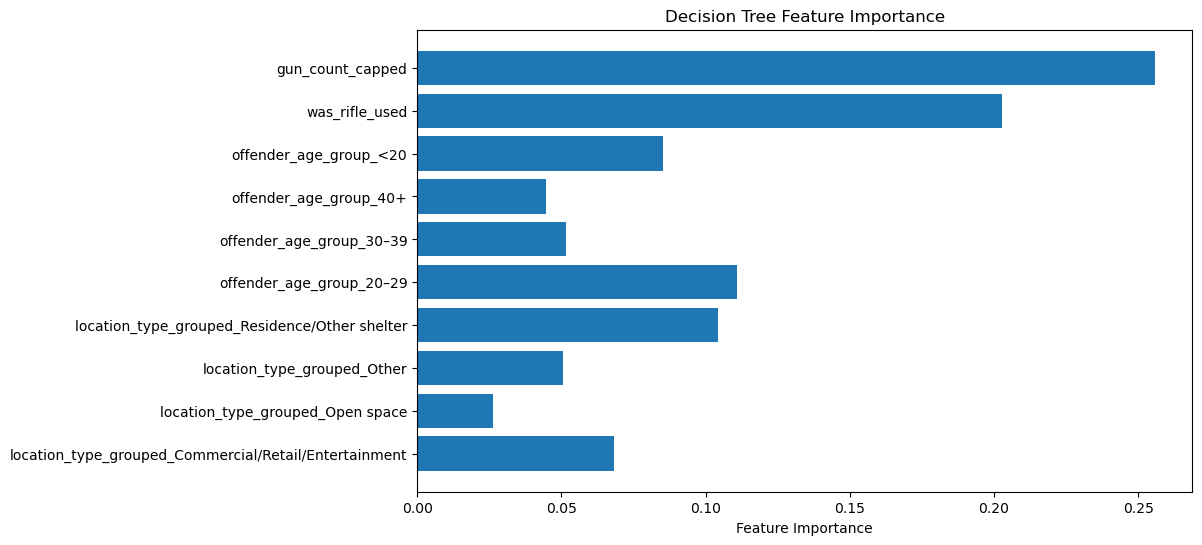

In [398]:
# Get feature names from OneHotEncoder
onehot_features = ct.named_transformers_['encoder'].get_feature_names_out(['location_type_grouped', 'offender_age_group'])

# Combine with the remaining numeric features
numeric_features = ['was_rifle_used', 'gun_count_capped']

# Final feature name list
feature_names = list(onehot_features) + numeric_features

# Now plot
importances = regressor.feature_importances_

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances)
plt.xlabel("Feature Importance")
plt.title("Decision Tree Feature Importance")
plt.show()

#### Our Insights
----------------


**Vapenrelaterade faktorer: ~46 % av modellens beslutsfattande**
- Antalet vapen är den starkaste drivkraften bakom det förväntade antalet offer.
- Användning av gevär ökar det förväntade antalet offer.

**Gärningspersoner**
- Den mest prediktiva åldersgruppen (20–29), vilket speglar högre risktagande eller större förekomst i incidenter.
- Yngre gärningspersoner (<20) bidrar påtagligt till variationen.
  
**Platskategorier**
- Bostad/Annat skydd (0.1043): Den mest prediktiva platskategorin.
- Kommersiell/Detaillhandel/Underhållning (0.0681): Måttligt inflytande
- Annan (0.0504) och Öppet område (0.0263): Minst prediktiva

### Conclusion
-----

####
- Starkt vapenstyrd, antalet vapen och användning av gevär dominerar.
- Gärningspersonens ålder tillför förklaringskraft, särskilt för yngre grupper.
- Platsens bidrar och kontexten spelar roll, eftersom detär mindre än tillgången på vapen.

**vapen > aktörer (ålder) > miljö (plats).**

### Next
-----

####
- **Kontrollera interaktioner:**
T.ex. gevärsanvändning × öppet område eller antal vapen × åldersgrupp. "Decision tree" fångar en del av detta, men "Random Forests" eller "Gradient Boosting" kan avslöja mer stabila mönster.
  
- **Partial dependence-plots:**
Visualisera hur det förväntade antalet offer förändras när "gun_count_capped" eller "was_rifle_used" varierar.

- **Korsvalidering:**
Bekräfta att dessa betydelserangordningar håller över olika datadelningar.
